In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, mean_squared_error
from time import process_time
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
import pywt
from pywt import wavedec
from scipy.signal import medfilt

In [2]:
# Read the CSV files containing ECG signals
ptbdb_normal = pd.read_csv('ptbdb_normal.csv', header=None)
ptbdb_abnormal = pd.read_csv('ptbdb_abnormal.csv', header=None)
BASIC_SRATE = 125

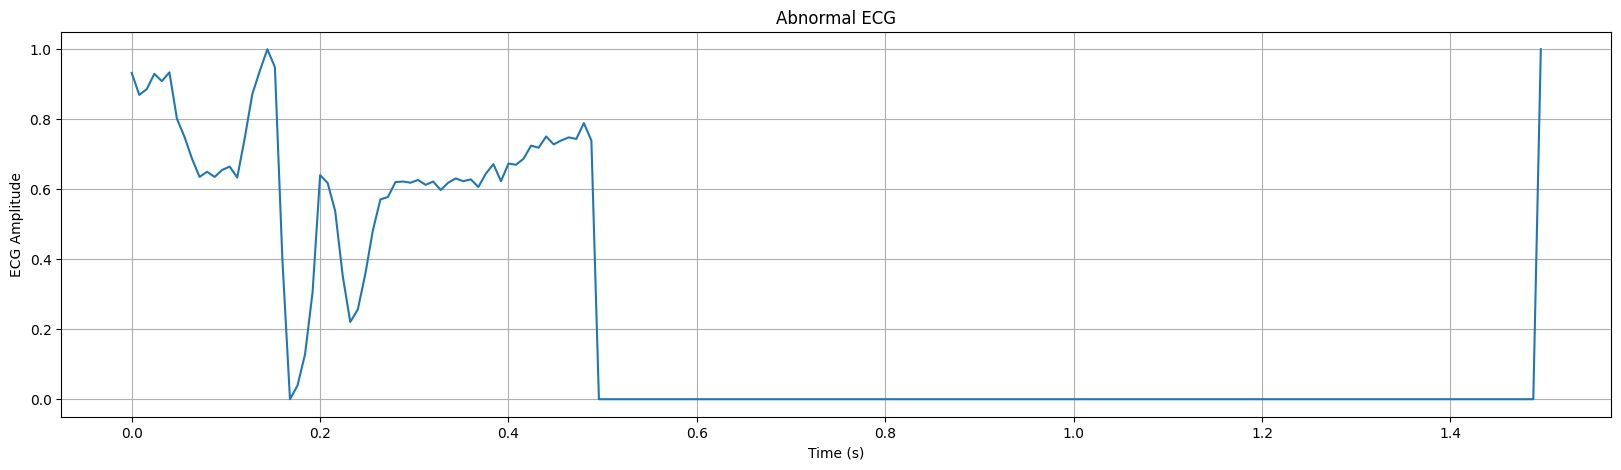

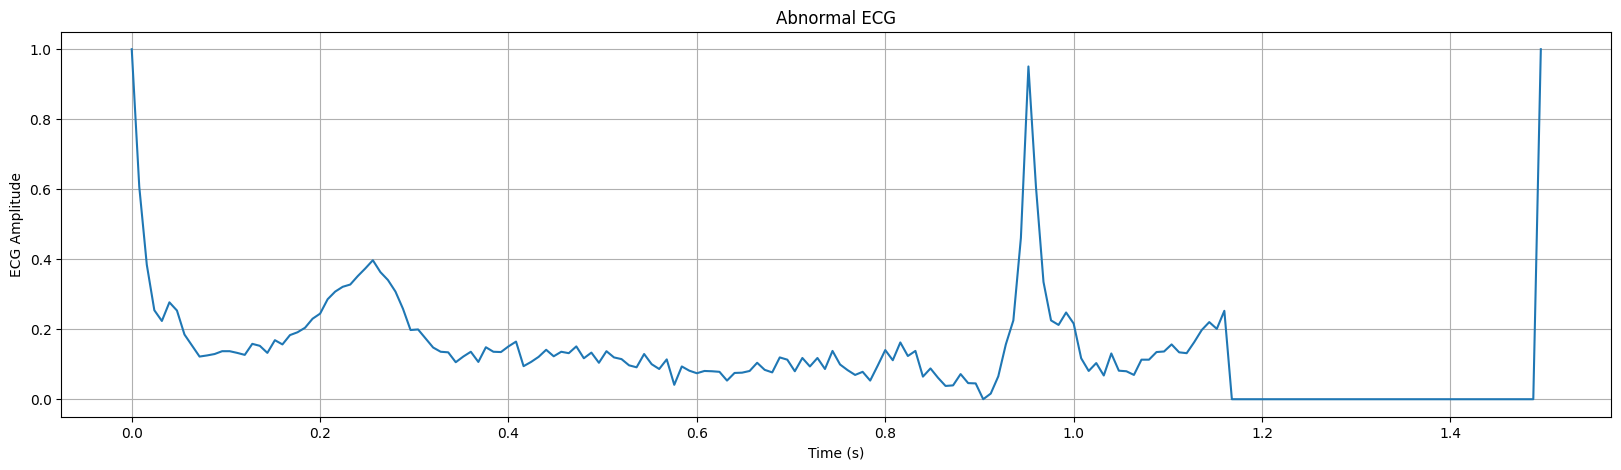

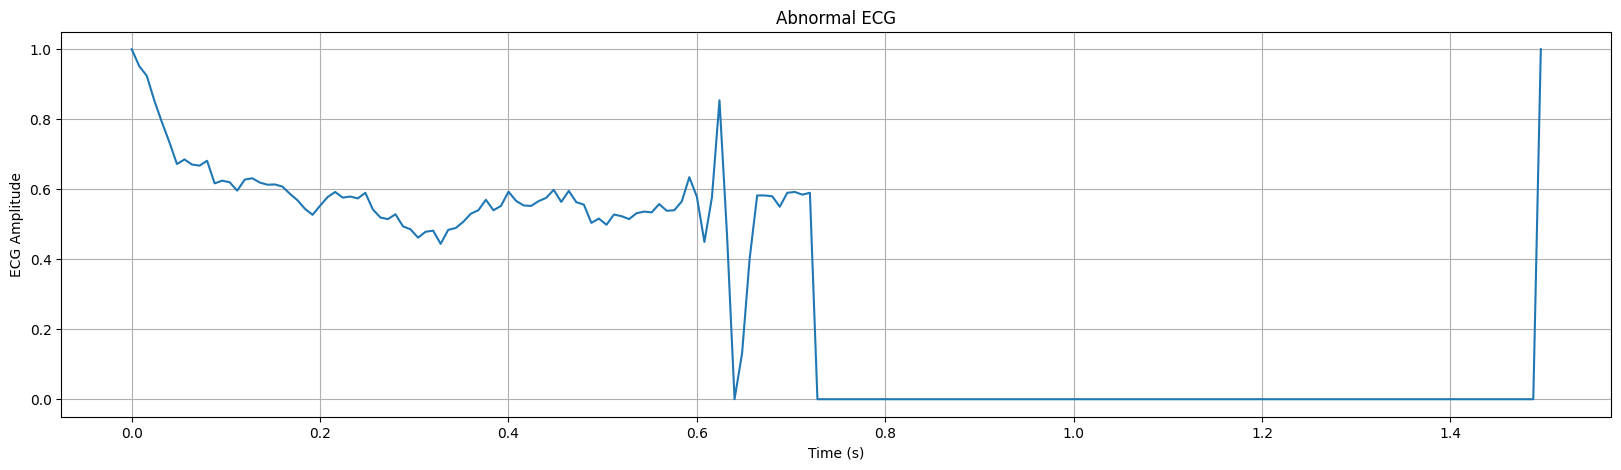

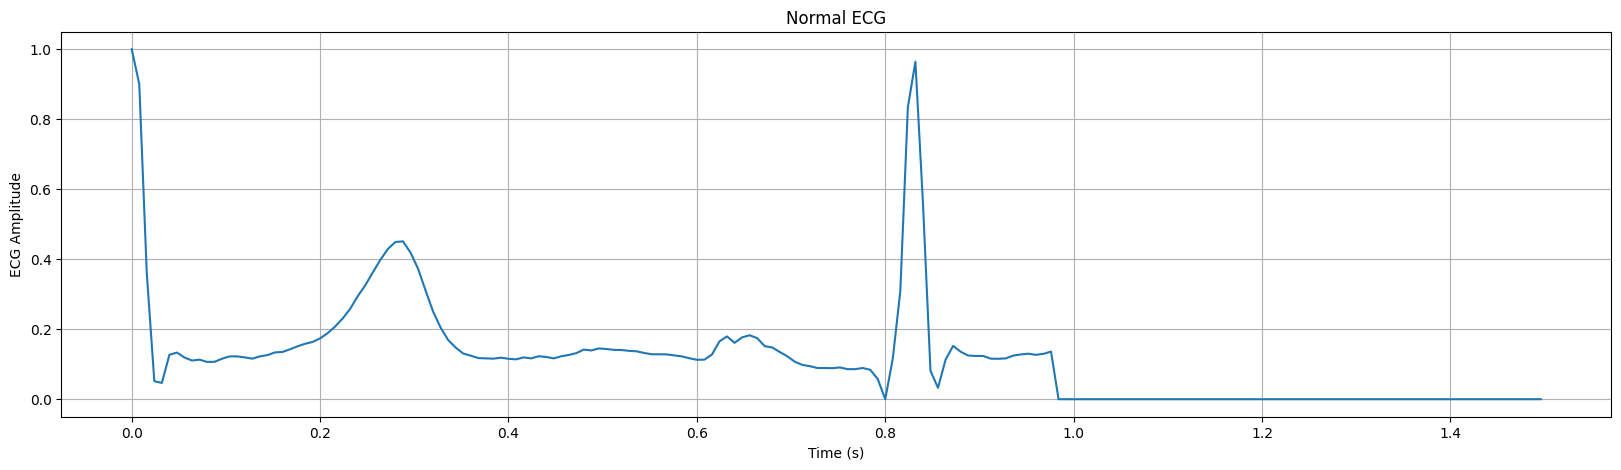

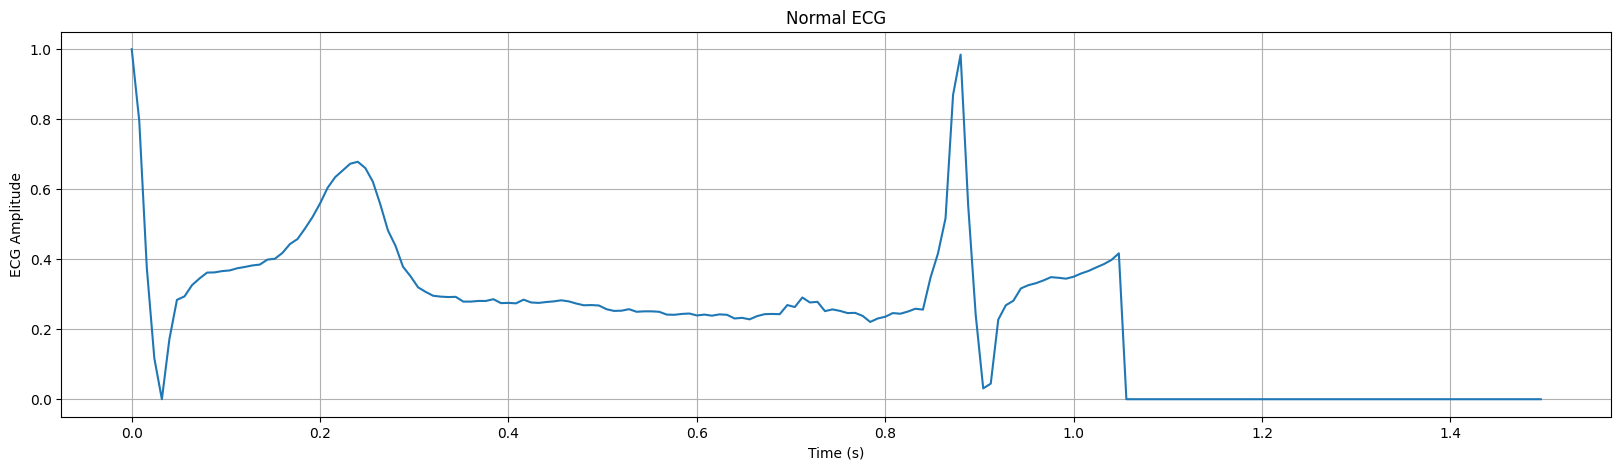

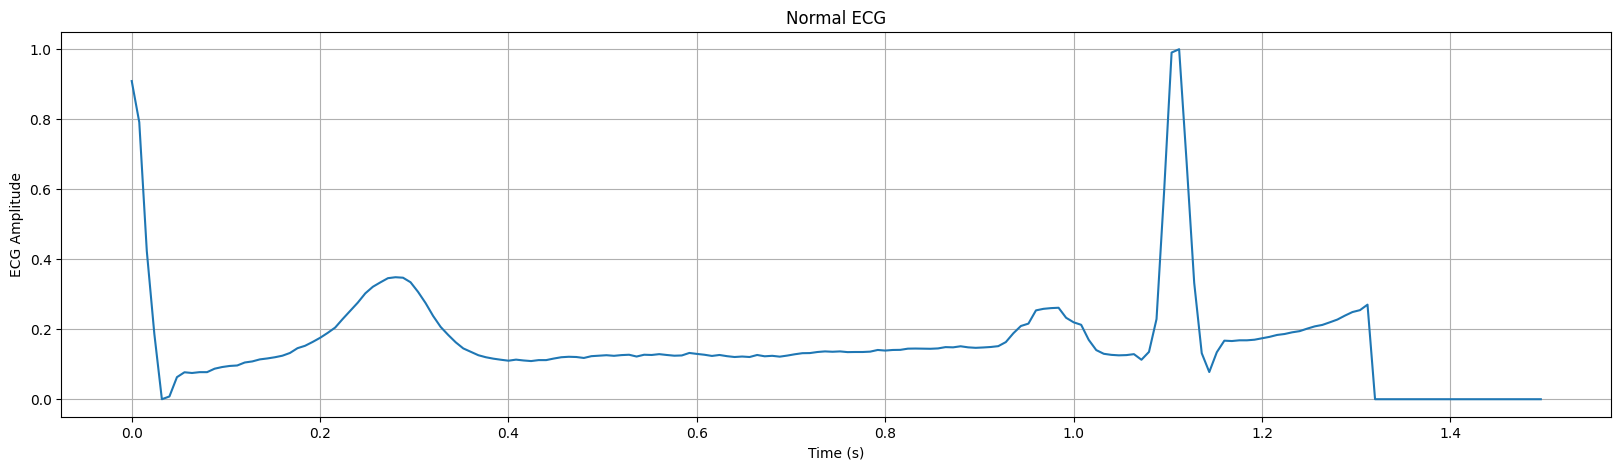

In [3]:
num_people = 3
selected_abnormal_data = ptbdb_abnormal.iloc[:num_people+1, :]

# Calculate time axis based on sampling rate (125 Hz)
time = [i / BASIC_SRATE for i in range(selected_abnormal_data.shape[1])]

# Plot ECG data for each person
for i in range(num_people):
    plt.figure(figsize=(20, 5))
    plt.plot(time, selected_abnormal_data.iloc[i, :])
    plt.title(f'Abnormal ECG')
    plt.xlabel('Time (s)')
    plt.ylabel('ECG Amplitude')
    plt.grid(True)
    plt.show()

selected_normal_data = ptbdb_normal.iloc[:num_people+10, :]

# Calculate time axis based on sampling rate (125 Hz)
time = [i / BASIC_SRATE for i in range(selected_normal_data.shape[1])]

# Plot ECG data for each person
for i in range(num_people):
    plt.figure(figsize=(20, 5))
    plt.plot(time, selected_normal_data.iloc[i, :])
    plt.title(f'Normal ECG')
    plt.xlabel('Time (s)')
    plt.ylabel('ECG Amplitude')
    plt.grid(True)
    plt.show()

In [4]:

def denoise_signal(X, dwt_transform, dlevels, cutoff_low, cutoff_high):
    coeffs = wavedec(X, dwt_transform, level=dlevels)   # wavelet transform 'bior4.4'
    # scale 0 to cutoff_low 
    for ca in range(0,cutoff_low):
        coeffs[ca]=np.multiply(coeffs[ca],[0.0])
    # scale cutoff_high to end
    for ca in range(cutoff_high, len(coeffs)):
        coeffs[ca]=np.multiply(coeffs[ca],[0.0])
    Y = pywt.waverec(coeffs, dwt_transform) # inverse wavelet transform
    return Y  
def get_median_filter_width(sampling_rate, duration):
    res = int( sampling_rate*duration )
    res += ((res%2) - 1) # needs to be an odd number
    return res
# baseline fitting by filtering
# === Define Filtering Params for Baseline fitting Leads======================
ms_flt_array = [0.2,0.6]    #<-- length of baseline fitting filters (in seconds)
mfa = np.zeros(len(ms_flt_array), dtype='int')
for i in range(0, len(ms_flt_array)):
    mfa[i] = get_median_filter_width(BASIC_SRATE,ms_flt_array[i])

def filter_signal(X):
    global mfa
    X0 = X  #read orignal signal
    for mi in range(0,len(mfa)):
        X0 = medfilt(X0,mfa[mi]) # apply median filter one by one on top of each other
    X0 = np.subtract(X,X0)  # finally subtract from orignal signal
    return X0


In [5]:
# Combine normal and abnormal datasets
ptbdb_combined = pd.concat([ptbdb_normal, ptbdb_abnormal], ignore_index=True, axis=0)

# Shuffle the combined dataset
ptbdb_combined_shuffled = ptbdb_combined.sample(frac=1, random_state=42)

# Denoise and filter the signals
filtered_denoised_signals = []
for index, row in ptbdb_combined_shuffled.iterrows():
    denoised_signal = denoise_signal(row.values[:-1], 'bior4.4', 9, 1, 8)  # Denoise all columns except the last one (labels)
    filtered_denoised_signal = filter_signal(denoised_signal)  # Apply filtering to denoised signal
    filtered_denoised_signals.append(filtered_denoised_signal)

# Convert the filtered and denoised signals list to a DataFrame
filtered_denoised_df = pd.DataFrame(filtered_denoised_signals)

# Extract features (X) and labels (y) from the filtered and denoised DataFrame
X = filtered_denoised_df
y = ptbdb_combined_shuffled.iloc[:, -1]  # The last column contains the labels

# Split the data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)


/Users/louis/Library/Python/3.9/lib/python/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 9 is too high: all coefficients will experience boundary effects.
  warnings.warn(


/Users/louis/Library/Python/3.9/lib/python/site-packages/pywt/_multilevel.py:43: UserWarning: Level value of 9 is too high: all coefficients will experience boundary effects.
  warnings.warn(


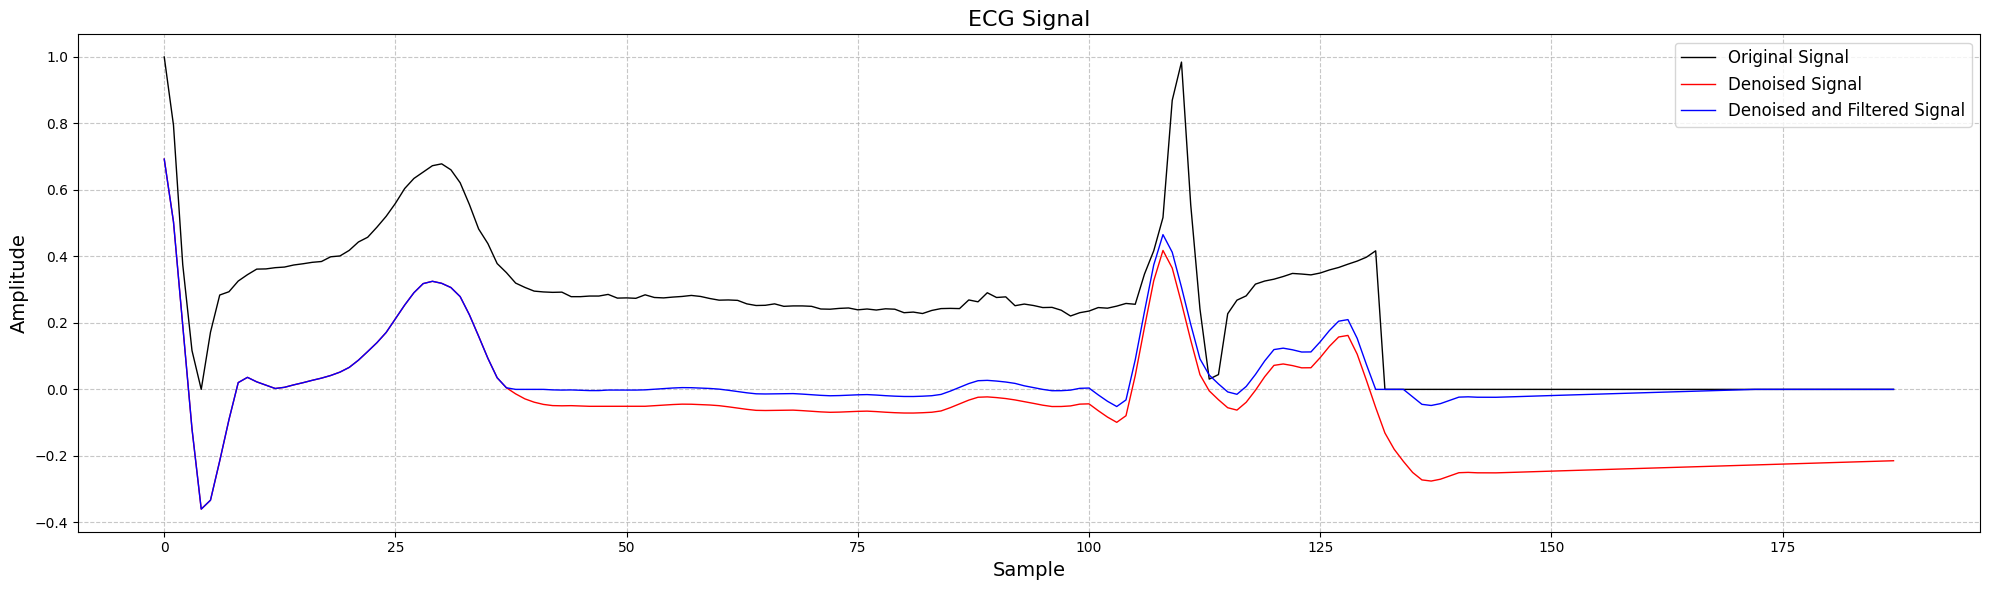

In [33]:
# Select an example abnormal signal from the original dataset
example_abnormal_signal = ptbdb_normal.iloc[1].values

# Denoise the selected signal
example_denoised_signal = denoise_signal(example_abnormal_signal, 'bior4.4', 9, 1, 8)

# Filter the denoised signal
example_filtered_denoised_signal = filter_signal(example_denoised_signal)

# Plot the original, denoised, and filtered signals
plt.figure(figsize=(20, 6))


plt.plot(example_abnormal_signal, color='black', label='Original Signal', linewidth=1)
plt.plot(example_denoised_signal, color='red', label='Denoised Signal', linewidth=1)
plt.plot(example_filtered_denoised_signal, color='blue', label='Denoised and Filtered Signal', linewidth=1)

plt.title('ECG Signal', fontsize=16)
plt.xlabel('Sample', fontsize=14)
plt.ylabel('Amplitude', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()

In [7]:
# ptbdb_normal= pd.read_csv('ptbdb_normal.csv', header=None)
# ptbdb_abnormal=pd.read_csv('ptbdb_abnormal.csv',header=None)

# ptbdb_combined = pd.concat([ptbdb_normal, ptbdb_abnormal], ignore_index=True, axis=0)
# ptbdb_combined_shuffled = ptbdb_combined.sample(frac=1, random_state=42)

# X = ptbdb_combined_shuffled.iloc[:, :-1] 
# y = ptbdb_combined_shuffled.iloc[:, -1] #The final element of each row denotes the class (0:normal),(1:abnormal)

# x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

Logistic Regression

By using Logistic Regression

 Accuracy:  0.7986946066643765 
loss function:  0.2013053933356235


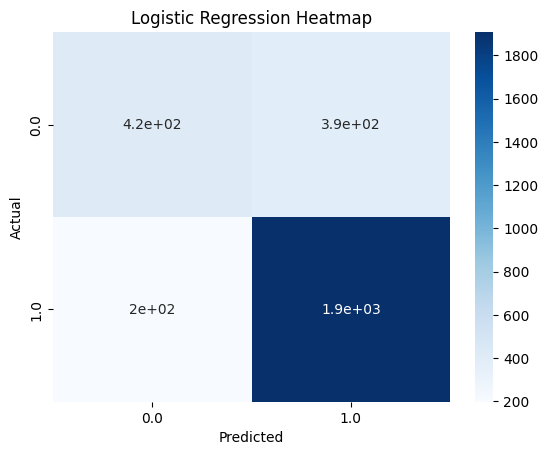

In [8]:
model=LogisticRegression()
model.fit(x_train , y_train)
yp = model.predict(x_test)
accuracy1 = accuracy_score(y_test,yp)
loss1 = mean_squared_error(y_test,yp)
print("By using Logistic Regression\n\n",
      "Accuracy: ",accuracy1,
      "\nloss function: ",loss1)

fig = plt.figure()
plt.title("Logistic Regression Heatmap")
m = pd.crosstab(y_test, yp, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(m,annot=True, cmap="Blues");

In [9]:
model = LogisticRegression()

# Define the hyperparameter grid
param_grid = {
    'penalty': ['l1', 'l2'],  # Regularization penalty
    'C': [0.001, 0.01, 0.1, 1, 10, 100],  # Inverse of regularization strength
    'solver': ['liblinear', 'saga']  # Algorithm to use in the optimization problem
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)


grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_ 

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


/Users/louis/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/louis/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/louis/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/louis/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/louis/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/louis/Library/Python/3.9/lib/pyth

Best Parameters: {'C': 100, 'penalty': 'l1', 'solver': 'liblinear'}
Best Score: 0.8327460866203656


/Users/louis/Library/Python/3.9/lib/python/site-packages/sklearn/svm/_base.py:1237: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Optimized Logistic Regression

By using Logistic Regression

 Accuracy:  0.8079697698385434 
loss function:  0.19203023016145654


/Users/louis/Library/Python/3.9/lib/python/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


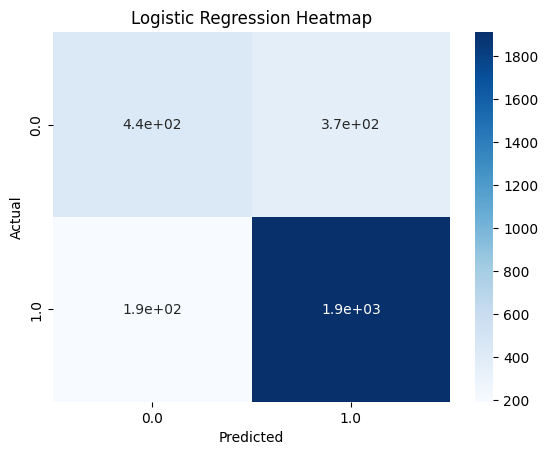

In [10]:
model=LogisticRegression(C=1, penalty='l1', solver='saga')
model.fit(x_train , y_train)
yp = model.predict(x_test)
accuracy1 = accuracy_score(y_test,yp)
loss1 = mean_squared_error(y_test,yp)
print("By using Logistic Regression\n\n",
      "Accuracy: ",accuracy1,
      "\nloss function: ",loss1)

fig = plt.figure()
plt.title("Logistic Regression Heatmap")
m = pd.crosstab(y_test, yp, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(m,annot=True, cmap="Blues");

Decision Tree

By using Decision Tree

 Accuracy:  0.9154929577464789 
loss function:  0.08450704225352113


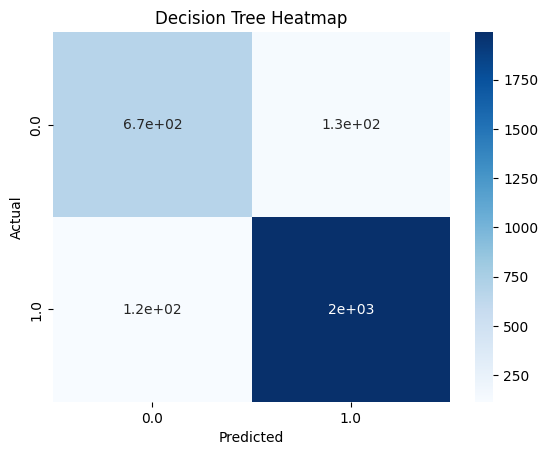

In [11]:
model = tree.DecisionTreeClassifier(random_state = 42)
model.fit(x_train , y_train)
yp = model.predict(x_test)
accuracy2 = accuracy_score(y_test,yp)
loss2 = mean_squared_error(y_test,yp)
print("By using Decision Tree\n\n",
      "Accuracy: ",accuracy2,
      "\nloss function: ",loss2,)

fig = plt.figure()
plt.title("Decision Tree Heatmap")
m = pd.crosstab(y_test, yp, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(m,annot=True, cmap='Blues');

In [12]:
model = DecisionTreeClassifier()

param_grid = {
    'criterion': ['gini', 'entropy'],  # Split criterion
    'max_depth': [None, 5, 10, 20],     # Maximum depth of the tree
    'min_samples_split': [2, 5, 10],    # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]       # Minimum number of samples required to be at a leaf node
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)


grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)


Fitting 5 folds for each of 72 candidates, totalling 360 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Score: 0.9244049331674876


Optimized Decition Tree

By using Decision Tree

 Accuracy:  0.9336997595328066 
loss function:  0.0663002404671934


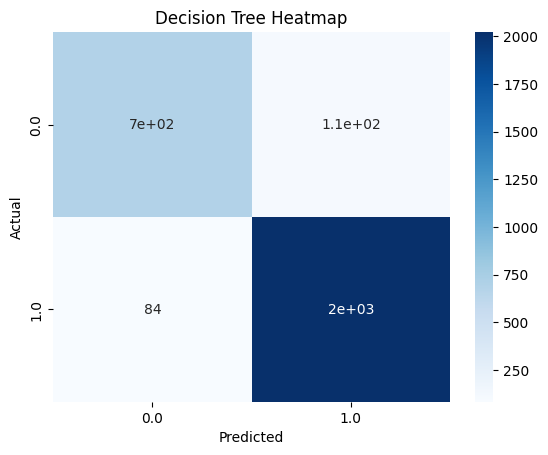

In [13]:
model = tree.DecisionTreeClassifier(criterion='entropy', max_depth=None, min_samples_leaf=1, min_samples_split=2, random_state = 42)
model.fit(x_train , y_train)
yp = model.predict(x_test)
accuracy2 = accuracy_score(y_test,yp)
loss2 = mean_squared_error(y_test,yp)
print("By using Decision Tree\n\n",
      "Accuracy: ",accuracy2,
      "\nloss function: ",loss2,)

fig = plt.figure()
plt.title("Decision Tree Heatmap")
m = pd.crosstab(y_test, yp, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(m,annot=True, cmap='Blues');

Random Forest

By using Random Forest

 Accuracy:  0.9725180350395053 
loss function:  0.027481964960494674


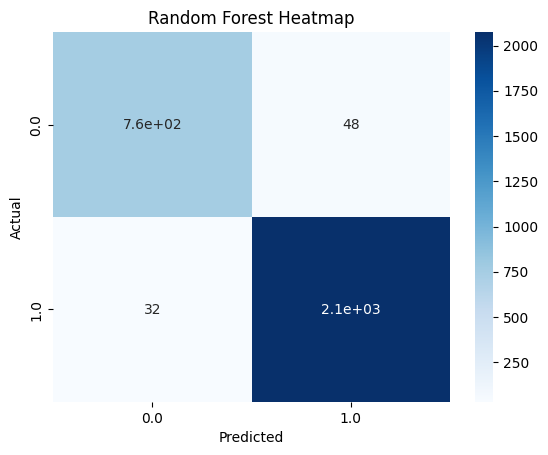

In [30]:
model = RandomForestClassifier(random_state = 42)
model.fit(x_train , y_train)
yp = model.predict(x_test)
accuracy3 = accuracy_score(y_test,yp)
loss3 = mean_squared_error(y_test,yp)
print("By using Random Forest\n\n",
      "Accuracy: ",accuracy3,
      "\nloss function: ",loss3)

fig = plt.figure()
plt.title("Random Forest Heatmap")
m = pd.crosstab(y_test, yp, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(m,annot=True, cmap='Blues');

In [20]:
model = RandomForestClassifier()

param_grid = {
    'n_estimators': [100, 200, 300],       # Number of trees in the forest
    'criterion': ['gini', 'entropy'],      # Split criterion
    'max_depth': [None, 5, 10, 20],        # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],       # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]          # Minimum number of samples required to be at a leaf node
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Fitting 5 folds for each of 216 candidates, totalling 1080 fits
Best Parameters: {'criterion': 'entropy', 'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
Best Score: 0.9734559321508722


Optimized Ramdom forest

By using Random Forest

 Accuracy:  0.971830985915493 
loss function:  0.028169014084507043


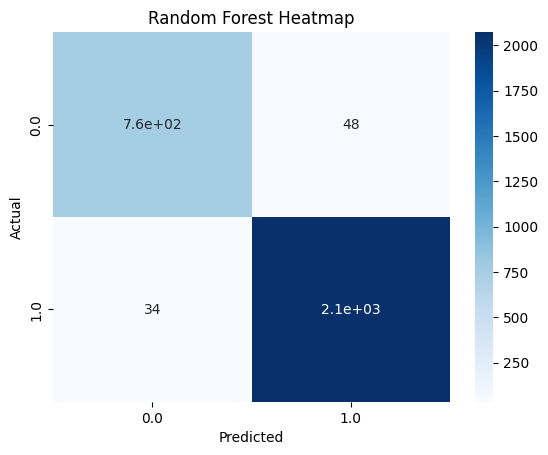

In [32]:
model = RandomForestClassifier(criterion='entropy', max_depth=None, min_samples_leaf=1, min_samples_split=2, n_estimators=100, random_state = 42)
model.fit(x_train , y_train)
yp = model.predict(x_test)
accuracy3 = accuracy_score(y_test,yp)
loss3 = mean_squared_error(y_test,yp)
print("By using Random Forest\n\n",
      "Accuracy: ",accuracy3,
      "\nloss function: ",loss3)

fig = plt.figure()
plt.title("Random Forest Heatmap")
m = pd.crosstab(y_test, yp, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(m,annot=True, cmap='Blues');

Support Vector Machine

By using Support Vector Machine SVM

 Accuracy:  0.9227069735486088 
loss function:  0.07729302645139127


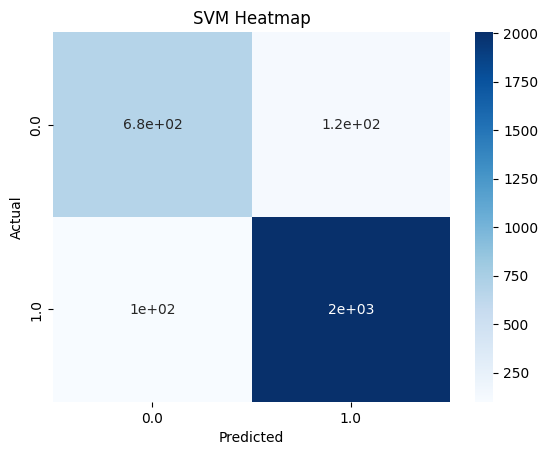

In [17]:
model = svm.SVC(random_state = 42)
model.fit(x_train , y_train)
yp = model.predict(x_test)
score2 = accuracy_score(y_test,yp)
loss2  = mean_squared_error(y_test,yp)
print("By using Support Vector Machine SVM\n\n",
      "Accuracy: ",score2,
      "\nloss function: ",loss2)

fig = plt.figure()
plt.title("SVM Heatmap")
m = pd.crosstab(y_test, yp, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(m,annot=True, cmap='Blues');

In [19]:
model = svm.SVC()

param_grid = {
    'C': [0.1, 1, 10],           # Regularization parameter
    'kernel': ['linear', 'rbf'], # Kernel type
    'gamma': ['scale', 'auto']   # Kernel coefficient
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

grid_search.fit(x_train, y_train)

best_params = grid_search.best_params_
best_score = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Score:", best_score)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best Parameters: {'C': 10, 'gamma': 'scale', 'kernel': 'rbf'}
Best Score: 0.9523235714633509


Optomized Support Vector Machine

By using Support Vector Machine SVM

 Accuracy:  0.9536241841291653 
loss function:  0.046375815870834766


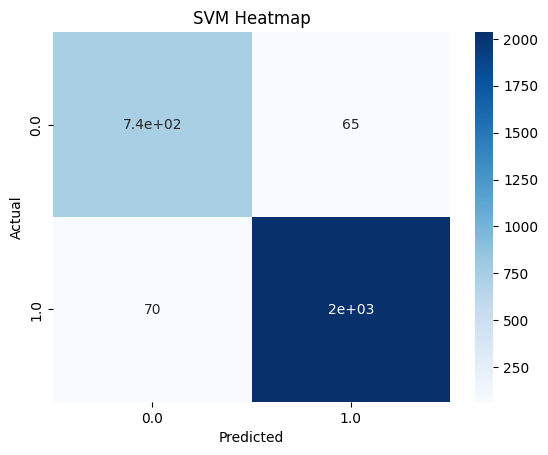

In [18]:
model = svm.SVC(C=10, gamma='scale', kernel='rbf', random_state = 42)
model.fit(x_train , y_train)
yp = model.predict(x_test)
score2 = accuracy_score(y_test,yp)
loss2  = mean_squared_error(y_test,yp)
print("By using Support Vector Machine SVM\n\n",
      "Accuracy: ",score2,
      "\nloss function: ",loss2)

fig = plt.figure()
plt.title("SVM Heatmap")
m = pd.crosstab(y_test, yp, rownames=['Actual'], colnames=['Predicted'])
sns.heatmap(m,annot=True, cmap='Blues');